# `pymathutils.findiff` submodule tests

In [1]:
import sys
from pathlib import Path

nb_dir = Path().resolve()
tests_dir = (nb_dir / ".." / "src" / "python").resolve()
sys.path.insert(0, str(tests_dir))

In [2]:
import numpy as np
from pymathutils.findiff import FiniteDifference1D
from pymathutils.findiff.pyutils import linspace_nu, is_uniform_grid
import matplotlib.pyplot as plt
from pyfindiff import FiniteDifferenceOps

def run_fornberg_weights_test(iterations=25, tol=1e-12):
    from pymathutils.findiff import fornberg_weights
    from pyfindiff import fornberg_weights as pyfornberg_weights
    from pyfindiff import linspace_nu
    import numpy as np

    for iter in range(iterations):
        print(13 * "-" + f"\n{iter=}")
        N = np.random.randint(55, 555)
        stencil_radius = np.random.randint(1, 8)
        d_max = np.random.randint(1, 7)

        i = np.random.randint(int(N / 4), N - int(N / 4))
        a, b = np.sort(np.random.randint(1, 5) * np.random.rand(2))
        jitter = np.random.rand()

        x = linspace_nu(start=a, stop=b, num=N, jitter=0.05 * jitter, endpoint=False)
        x0 = x[i]
        stencil = np.arange(-stencil_radius, stencil_radius + 1)
        x_stencil = x[i + stencil]

        fw = fornberg_weights(x_stencil, x0, d_max)
        pyfw = pyfornberg_weights(x_stencil, x0, d_max)
        Linf = np.linalg.norm(fw - pyfw, np.inf) / np.linalg.norm(pyfw, np.inf)
        L2 = np.linalg.norm(fw - pyfw, 2) / np.linalg.norm(pyfw, 2)
        print(f"{Linf=}, {L2=}")
        if Linf > tol or L2 > tol:
            print("exceeded tolerance")
            break




#
# x = np.linspace(0, 1, 3333, endpoint=False)
# stencil = np.array([-1, 0, 1])
# deriv_order = 1
# period = 1
# boundary0_stencil = stencil + 1.0
# boundary1_stencil = stencil - 1.0

# op = FiniteDifference1D.build_from(
#     x=x,
#     stencil=stencil,
#     deriv_order=deriv_order,
#     period=period,
#     # boundary0_stencil=boundary0_stencil,
#     # boundary1_stencil=boundary1_stencil,
# )
# op = FiniteDifference1D.build_periodic(
#     x=x,
#     stencil=stencil,
#     deriv_order=deriv_order,
#     period=period,
#     # boundary0_stencil=boundary0_stencil,
#     # boundary1_stencil=boundary1_stencil,
# )
# op = FiniteDifference1D.build_nonperiodic(
#     x=x,
#     stencil=stencil,
#     deriv_order=deriv_order,
#     boundary0_stencil=boundary0_stencil,
#     boundary1_stencil=boundary1_stencil,
# )
# y = np.sin(2 * np.pi * x)
# dy = op.apply(y)


def temp_get_stencil(x, acc, deriv_order):
    deriv_order = int(deriv_order)
    acc = int(acc)
    if deriv_order < 0 or acc < 1:
        raise ValueError(
            f"deriv_order >= 0 and acc >= 1 required, but {deriv_order=} and {acc=} were given."
        )
    x_is_uniform = is_uniform_grid(x, test_frac=0.1, tol=1e-6)
    stencil_width = deriv_order + acc
    if x_is_uniform and (deriv_order % 2 == 0):
        stencil_width -= 1
    if stencil_width % 2 == 0:
        stencil_width += 1
    stencil_radius = (stencil_width - 1) // 2

    bdry_stencil_width = deriv_order + acc
    if bdry_stencil_width % 2 == 0:
        bdry_stencil_width += 1
    bdry_stencil_radius = (bdry_stencil_width - 1) // 2

    stencil = np.arange(-stencil_radius, stencil_radius + 1)
    # boundary0_stencil = np.arange(0, 2 * bdry_stencil_radius + 1)
    # boundary1_stencil = np.arange(-2 * bdry_stencil_radius, 1)
    return stencil


def get_fornberg_stencils(acc, deriv_order, uniform_grid=False, periodic=False):
    deriv_order = int(deriv_order)
    acc = int(acc)
    if deriv_order < 0 or acc < 1:
        raise ValueError(
            f"deriv_order >= 0 and acc >= 1 required, but {deriv_order=} and {acc=} were given."
        )
    stencil_width = deriv_order + acc
    if uniform_grid and (deriv_order % 2 == 0):
        stencil_width -= 1
    if stencil_width % 2 == 0:
        stencil_width += 1
    stencil_radius = (stencil_width - 1) // 2

    bdry_stencil_width = deriv_order + acc
    if bdry_stencil_width % 2 == 0:
        bdry_stencil_width += 1
    bdry_stencil_radius = (bdry_stencil_width - 1) // 2

    stencil = np.arange(-stencil_radius, stencil_radius + 1)
    boundary0_stencil = np.arange(0, 2 * bdry_stencil_radius + 1)
    boundary1_stencil = np.arange(-2 * bdry_stencil_radius, 1)

    return {
        "interior": stencil,
        "boundary0": boundary0_stencil,
        "boundary1": boundary1_stencil,
    }


def diff_fornberg_test(
    min_deriv_order=0, max_deriv_order=8, acc=2, periodic=True, rng=None
):
    rng = np.random.default_rng(0) if rng is None else rng
    # a, b = 0.0, 1.0
    # k = 2 * np.pi
    a, b = 0.0, 2 * np.pi
    k = 1
    _x = lambda s: np.cos(k * s)
    _y = lambda s: np.sin(k * s)
    jitter = 0.1
    Ns = 111
    s = linspace_nu(
        start=a, stop=b, num=Ns, jitter=jitter, endpoint=not periodic, rng=rng
    )
    # print(b-s[-1])
    x, y = _x(s), _y(s)
    r = np.vstack((x, y)).T
    deriv_orders = list(range(0, max_deriv_order + 1))
    # print(deriv_orders)
    # fornberg_diff_mats = get_forrnberg_findiff_mats(s, deriv_orders, acc=acc)
    # fornberg_dr_list = [fornberg_diff_mats[d] @ r for d in deriv_orders]
    stencils = [temp_get_stencil(s, acc, d) for d in deriv_orders]
    if periodic:
        FD = [
            FiniteDifference1D.build_periodic(
                x=s,
                stencil=stencil,
                deriv_order=d,
                period=b,
            )
            for stencil, d in zip(stencils, deriv_orders)
        ]
    else:
        FD = [
            FiniteDifference1D.build_nonperiodic(
                x=s,
                stencil=stencil,
                deriv_order=d,
                boundary0_stencil=stencil - min(stencil),
                boundary1_stencil=stencil - max(stencil),
            )
            for stencil, d in zip(stencils, deriv_orders)
        ]
    # FD = [
    #     FiniteDifference1D.build_from(
    #         x=s,
    #         stencil=stencil,
    #         deriv_order=d,
    #         period=b if periodic else None,
    #     )
    #     for stencil, d in zip(stencils, deriv_orders)
    # ]
    pyFD = FiniteDifferenceOps(
        x=s,
        max_deriv_order=max_deriv_order,
        acc=acc,
        period=b if periodic else None,
        rng=rng,
    )

    # FD.fornberg_findiff_mats = FD.update_fornberg_findiff_mats(periodic=True)
    fornberg_dr_list = [np.array([D.apply(x), D.apply(y)]).T for D in FD]
    pyfornberg_dr_list = [pyFD.diff(r, deriv_order=d, axis=0) for d in deriv_orders]

    ndr = r.copy()
    Ndr = [r]
    for n in range(max_deriv_order):
        ndr = np.gradient(ndr, s, edge_order=2, axis=0)
        Ndr.append(ndr)

    fig, axes = plt.subplots(
        1, max_deriv_order - min_deriv_order + 1, figsize=(3 * max_deriv_order, 8)
    )
    title = f"{Ns=}, {jitter=:.2f}, {periodic=}"
    fig.suptitle(title, fontsize=30)
    # print(len(fornberg_dr_list[min_deriv_order:]), len(Ndr[min_deriv_order:]), len(axes))
    d = min_deriv_order
    for rdr, pyrdr, ax in zip(
        fornberg_dr_list[min_deriv_order:],
        pyfornberg_dr_list[min_deriv_order:],
        axes,
    ):
        ax.plot(s, rdr[:, 0], label=f"order {d} fornberg - x")
        ax.plot(s, pyrdr[:, 0], label=f"order {d} pyfornberg - x")
        # ax.plot(s, ndr[:, 0], linestyle=":", label="numpy - x")
        # ax.plot(s, rdr[:, 1], label="roll - y")
        # ax.plot(s, ndr[:, 1], linestyle=":", label="numpy - y")
        ax.legend()
        d += 1
    plt.show()
    plt.close()

    fig, axes = plt.subplots(
        1, max_deriv_order - min_deriv_order + 1, figsize=(3 * max_deriv_order, 8)
    )
    title = f"{Ns=}, {jitter=:.2f}, {periodic=}"
    fig.suptitle(title, fontsize=30)

    d = min_deriv_order
    for rdr, pyrdr, ax in zip(
        fornberg_dr_list[min_deriv_order:],
        pyfornberg_dr_list[min_deriv_order:],
        axes,
    ):
        ax.plot(s, rdr[:, 0] - pyrdr[:, 0], label=f"order {d} fornberg - pyfornberg")
        ax.legend()
        d += 1
    plt.show()
    plt.close()
    # return FD





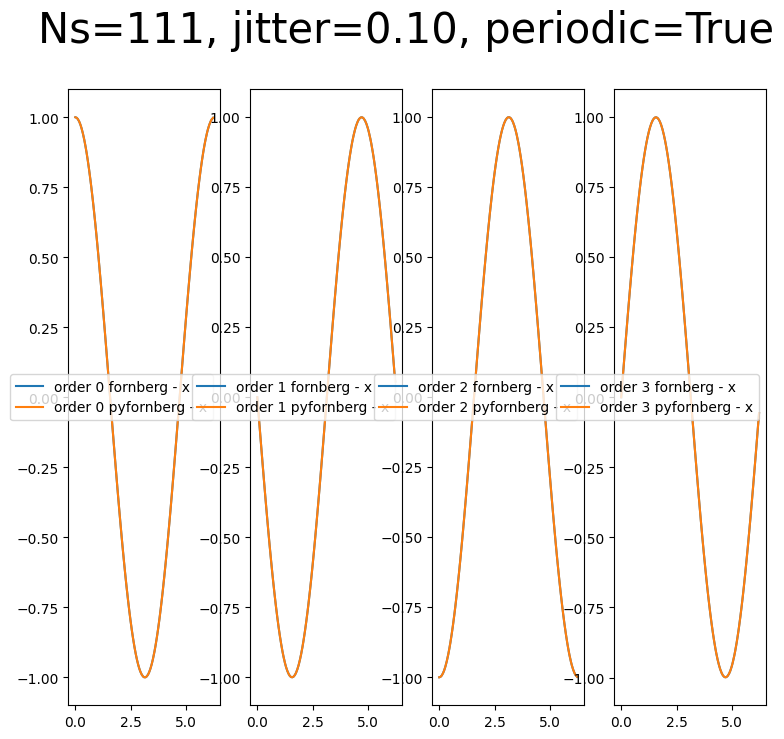

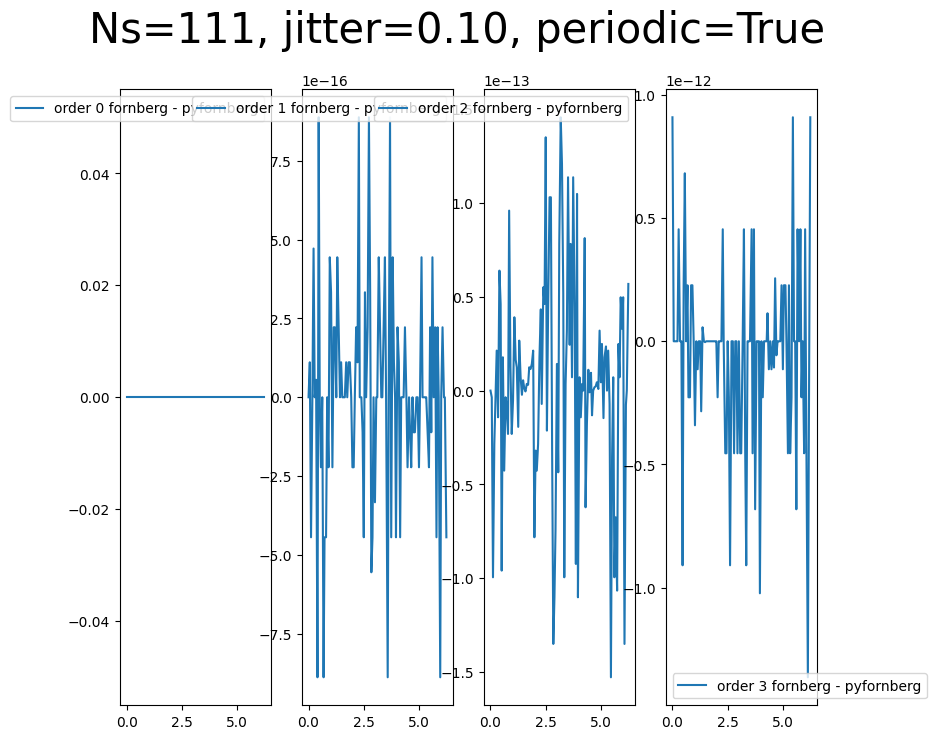

In [3]:
diff_fornberg_test(min_deriv_order=0, max_deriv_order=3, acc=2, periodic=True)